In [30]:
# conda activate anndata

import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

In [4]:
psi_data = "tasic_2018_ALM_STAR_SyntheticDataset1_20pcntCells_35SD_200samples_SJ_pseudobulk_min_observed0.05_minPsi0.05_PSI"
corr_df = pd.read_csv(f"data/{psi_data}_exon_corr.csv", index_col=0)

In [ ]:
# Load PSI data
sdata = ad.read_h5ad("data/tasic_2018_ALM_STAR_SJ_counts_annotated_PSI.hd5")
# Load gene expression data
adata = ad.read_h5ad("data/tasic_2018_ALM_STAR_model/tasic_2018_ALM_STAR_gene_counts_scVI.h5ad")

In [56]:
adata.obs['cell_subclass'] = adata.obs['cell_subclass'].astype(str).str.replace("/", "_", regex=False).str.replace(" ", "_", regex=False)
sdata.obs['cell_subclass'] = sdata.obs['cell_subclass'].astype(str).str.replace("/", "_", regex=False).str.replace(" ", "_", regex=False)

In [22]:
sum(adata.obs_names == sdata.obs_names)

9573

In [116]:
ctypes = corr_df.columns[1:]
gene_names_df = corr_df['Gene']

adata_raw = adata.raw.to_adata()

In [164]:
i = 13
ctype = ctypes[i]
print(ctype)

# --------

corr_df = corr_df.sort_values(ctype, ascending=False)

top_exons_df = corr_df[ctype][1:10]
top_exons = top_exons_df.index.tolist()
top_genes = gene_names_df.loc[top_exons].tolist()

cell_mask = adata.obs['cell_subclass'] == ctype

exon_mask = sdata.var_names.isin(top_exons)
sdata_sub = sdata[:, exon_mask]

gene_idx = np.where(adata_raw.var_names.isin(top_genes))[0]
adata_sub = adata_raw[:, gene_idx].copy()
adata_sub.X = adata_sub.X.toarray()

L2_3_IT


In [166]:
np.where(adata_raw.var_names.isin(top_genes))[0]

array([10641, 21054, 28138, 28306, 30428, 33514, 33719, 39016])

In [165]:
adata_sub.shape

(9573, 8)

In [158]:
adata_sub.shape

(9573, 8)

In [152]:
# Get mean PSI/gene expression by cell type

cols = [f"{ct}_{stat}" for ct in ctypes for stat in ("mean", "SE")]
ctype_psi_df = pd.DataFrame(columns=cols, index=top_exons) 
ctype_expr_df = pd.DataFrame(columns=cols, index=top_genes)

total_psi = np.mean(sdata_sub.X, axis=0) 
total_expr = np.mean(adata_sub.X, axis=0)

for idx, value in enumerate(ctypes):
    cell_mask = adata.obs['cell_subclass'] == value
    
    ctype_psi = np.mean(sdata_sub.X[cell_mask, :], axis=0)
    ctype_psi_df[value + "_mean"] = ctype_psi / total_psi 
    ctype_psi_se = np.sqrt(
        np.var(sdata_sub.X[cell_mask, :], axis=0) / np.sum(cell_mask)
    ) / total_psi
    ctype_psi_df[value + "_SE"] = ctype_psi_se
     
    ctype_expr = np.mean(adata_sub.X[cell_mask, :], axis=0) 
    ctype_expr_df[value + "_mean"] = ctype_expr / total_expr
    ctype_expr_se = np.sqrt(
        np.var(adata_sub.X[cell_mask, :], axis=0) / np.sum(cell_mask)
    ) / total_expr
    ctype_expr_df[value + "_SE"] = ctype_expr_se

ValueError: Length of values (8) does not match length of index (9)

In [145]:
def _cols_for(ctypes, stat):
    return [f"{ct}_{stat}" for ct in ctypes]

def plot_psi_for_exon(ctype_psi_df, ctypes, exon_id, out=None):
    if exon_id not in ctype_psi_df.index:
        raise KeyError(f"{exon_id} not in ctype_psi_df.index")

    mean_cols = _cols_for(ctypes, "mean")
    se_cols   = _cols_for(ctypes, "SE")

    means = ctype_psi_df.loc[exon_id, mean_cols].astype(float).values
    errs  = ctype_psi_df.loc[exon_id, se_cols].astype(float).values
    errs = errs * 2.0
    
    x = np.arange(len(ctypes))
    plt.figure()
    plt.bar(x, means, yerr=errs, capsize=3)
    plt.xticks(x, ctypes, rotation=45, ha="right")
    plt.ylabel("Mean PSI (normalized)")
    plt.title(f"PSI for {exon_id} by cell type")
    plt.tight_layout()
    if out:
        plt.savefig(out, dpi=300)
    plt.show()

def plot_expr_for_gene(ctype_expr_df, ctypes, gene_id, out=None):
    if gene_id not in ctype_expr_df.index:
        raise KeyError(f"{gene_id} not in ctype_expr_df.index")

    mean_cols = _cols_for(ctypes, "mean")
    se_cols   = _cols_for(ctypes, "SE")

    means = ctype_expr_df.loc[gene_id, mean_cols].astype(float).values
    errs  = ctype_expr_df.loc[gene_id, se_cols].astype(float).values
    errs = errs * 2.0
    
    x = np.arange(len(ctypes))
    plt.figure()
    plt.bar(x, means, yerr=errs, capsize=3)
    plt.xticks(x, ctypes, rotation=45, ha="right")
    plt.ylabel("Mean expression (normalized)")
    plt.title(f"Expression for {gene_id} by cell type")
    plt.tight_layout()
    if out:
        plt.savefig(out, dpi=300)
    plt.show()

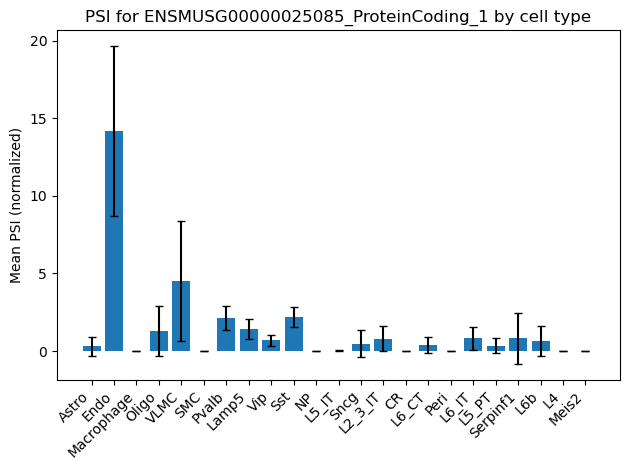

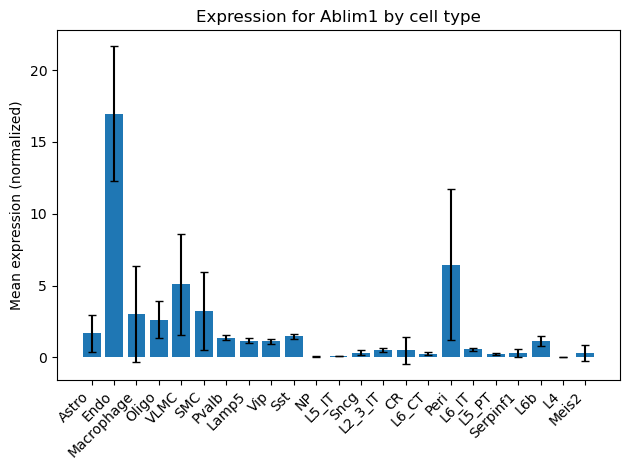

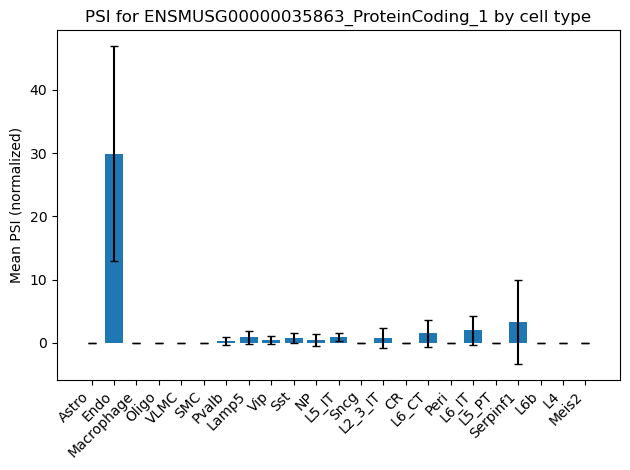

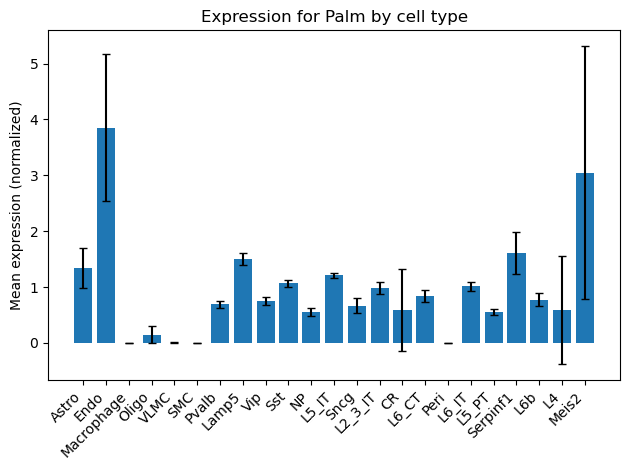

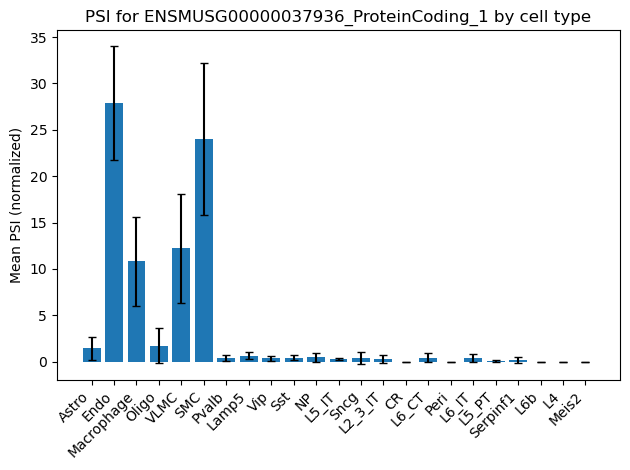

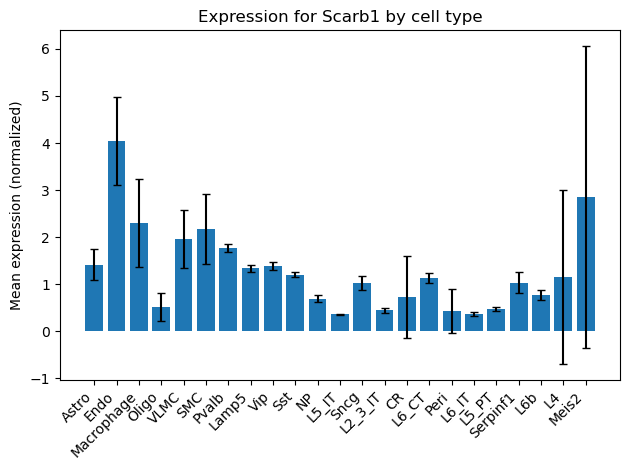

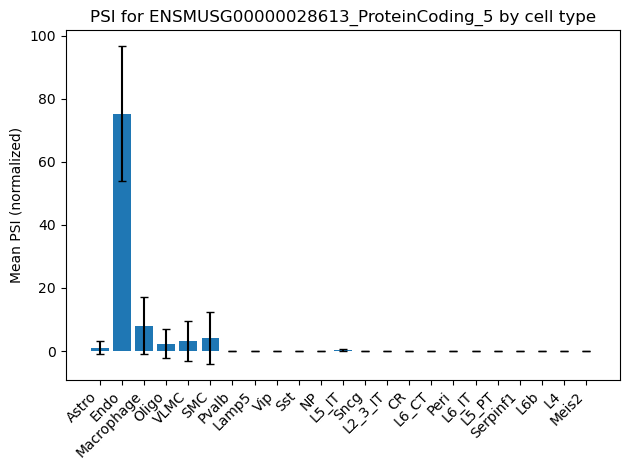

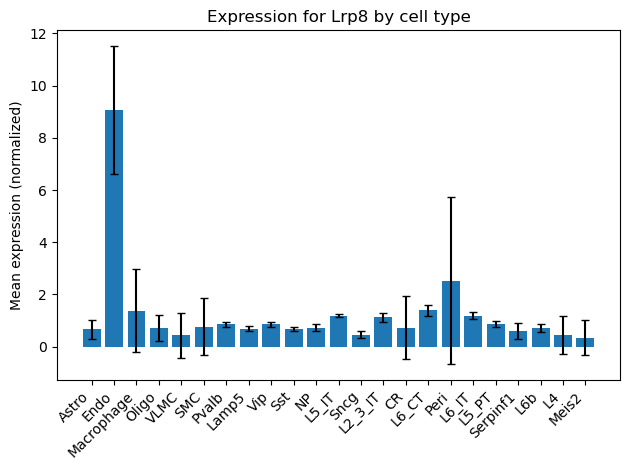

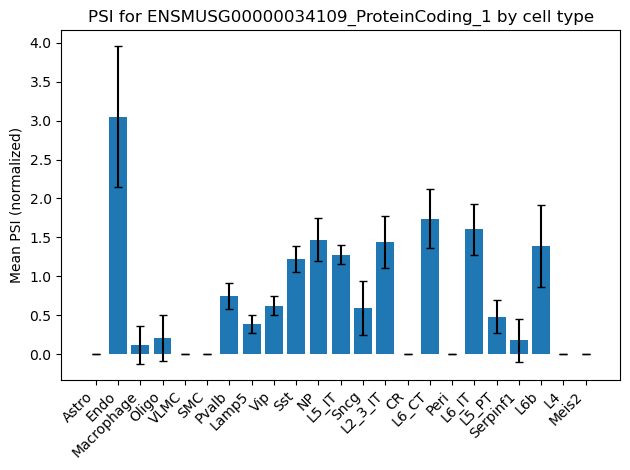

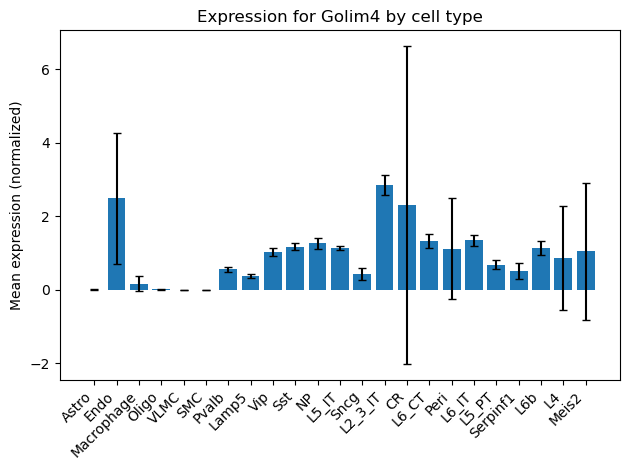

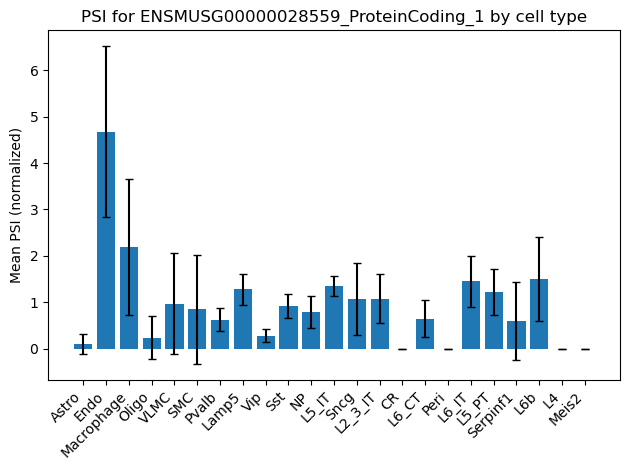

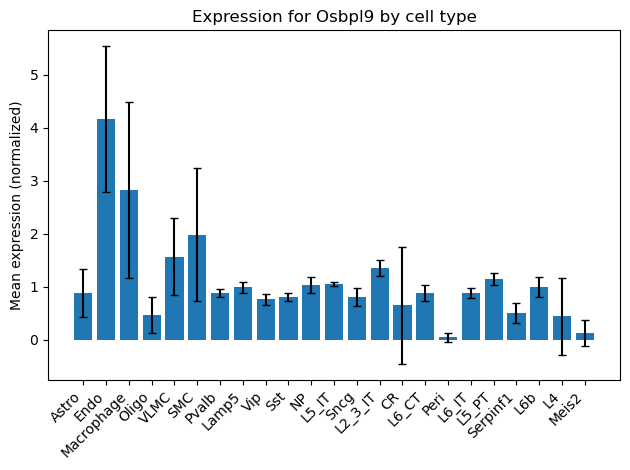

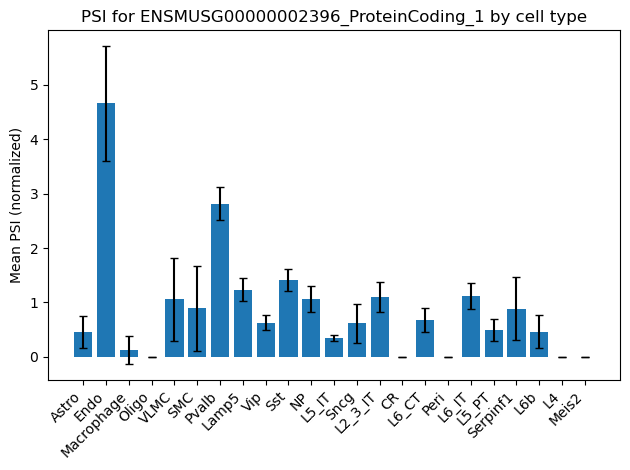

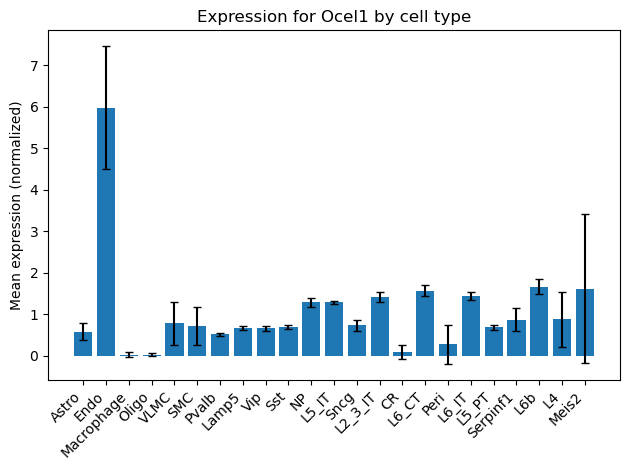

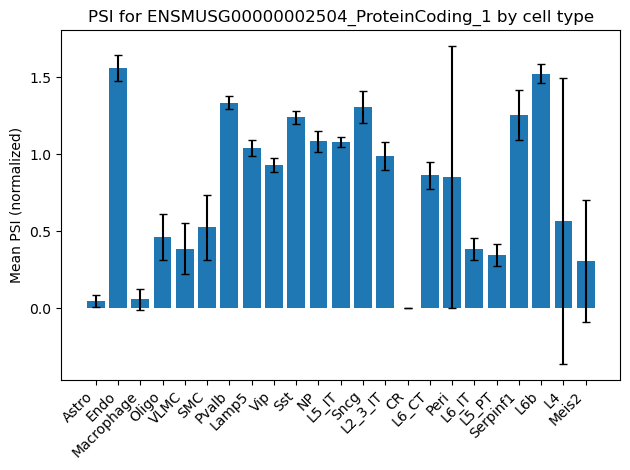

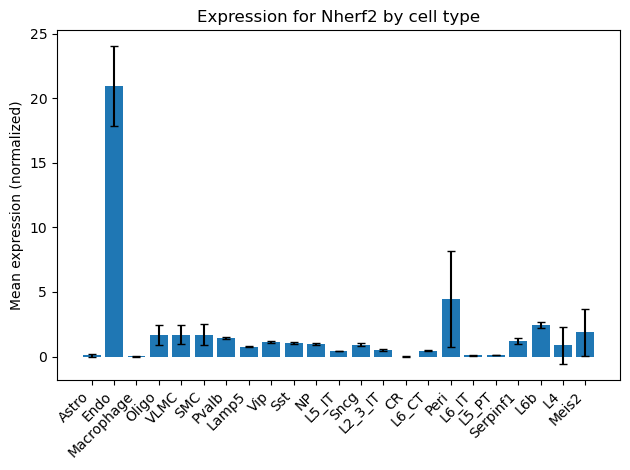

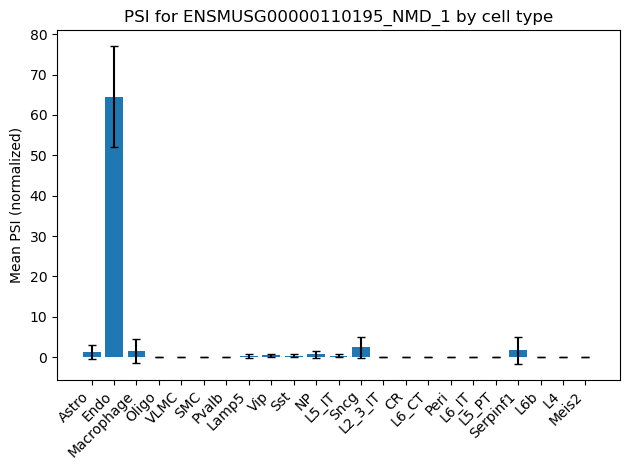

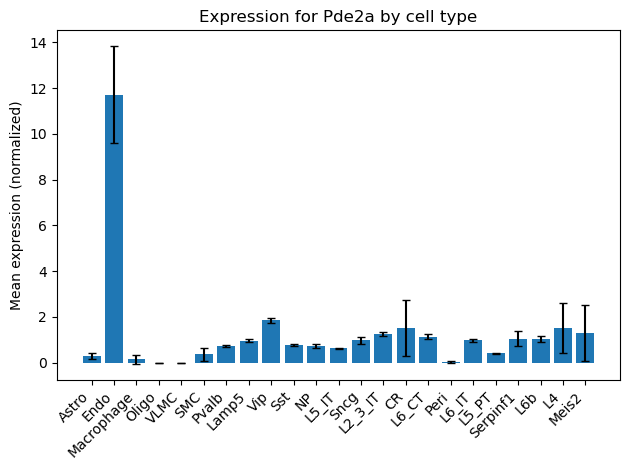

In [148]:
# plot_psi_for_exon(ctype_psi_df, ctypes, exon_id="exon_ABC")
# plot_expr_for_gene(ctype_expr_df, ctypes, gene_id="MALAT1")

# batch
for idx, val in enumerate(top_exons):
    plot_psi_for_exon(ctype_psi_df, ctypes, top_exons[idx])
    plot_expr_for_gene(ctype_expr_df, ctypes, top_genes[idx])
